In [1]:
!pip install opencv-contrib-python Pillow matplotlib torch torchvision

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import shutil
import itertools
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

**Routine to Download the Images from GitHub**

In [3]:
# Download the files if not already present
import os
import zipfile
import requests
from io import BytesIO

# Define the local directory path where you expect the images to be
local_dir = "Images"

# URL of the GitHub repo's zip file
url = "https://github.com/morrissoftware1229/MonetGAN/archive/refs/heads/main.zip"

# Check if the directory exists and contains any files
if not os.path.exists(local_dir) or not os.listdir(local_dir):
    print("Downloading and extracting Images folder...")

    # Send a request to fetch the data from the URL
    response = requests.get(url)
    zip_file = zipfile.ZipFile(BytesIO(response.content))

    # Define the path of the desired folder in the repo
    folder_path = "MonetGAN-main/Images/"

    # Extract only the specific folder from the zip
    for file in zip_file.namelist():
        if file.startswith(folder_path):
            zip_file.extract(file)

    # Rename the extracted folder for easier access (optional)
    os.rename("MonetGAN-main/Images", local_dir)

    print("Download and extraction complete.")
else:
    print("Images folder already exists. No download needed.")

# List the contents of the folder to verify (optional)
print("Contents of the Images folder:")
!ls {local_dir}

Download and extraction complete.
Contents of the Images folder:
monet_jpg  monet_tfrec	photo_jpg  photo_tfrec


In [4]:
BATCH_SIZE = 5
MONET_IMAGES_PATH = "./Images/monet_jpg/"
TEST_IMAGES_PATH = "./Images/photo_jpg/"

lr = 0.0001
beta1 = 0.5
beta2 = 0.996
n_epoches = 90
decay_epoch = 40
display_epoch = 25

In [5]:
transforms_dataset = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
class ImageDataset(Dataset):
    def __init__(self, directory_x, directory_y, test=False, transforms=None):
        self.transforms = transforms

        if test:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[250:]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[250:301]]
        else:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[:250]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[:250]]

    def __len__(self):
        return len(self.monet_images_X)

    def __getitem__(self, index):
        x_img =  Image.open(self.monet_images_X[index])
        y_img =  Image.open(self.test_images_Y[index])

        if self.transforms is not None:
            x_img = self.transforms(x_img)
            y_img = self.transforms(y_img)
        return x_img, y_img

In [7]:
train_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=False, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=True, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.scale_factor = 16

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        return self.model(x)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        self.initial = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(in_channels, 64, 2 * in_channels + 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.downsample_blocks = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(num_residual_blocks)])

        self.upsample_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.output = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(64, in_channels, 2 * in_channels + 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)

In [10]:
G_XY = GeneratorResNet(3, num_residual_blocks=9)
D_Y = Discriminator(3)

G_YX = GeneratorResNet(3, num_residual_blocks=9)
D_X = Discriminator(3)

In [11]:
# Check for CUDA availability and define the Tensor type accordingly
cuda_available = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda_available else torch.Tensor
print(f'CUDA Available: {cuda_available}')

# Transfer models to CUDA if available
models = [G_XY, D_Y, G_YX, D_X]
for model in models:
    if cuda_available:
        model.cuda()

gan_loss = nn.MSELoss().cuda()
cycle_loss = nn.L1Loss().cuda()
identity_loss = nn.L1Loss().cuda()

CUDA Available: True


In [12]:
optimizer_G = torch.optim.Adam(itertools.chain(G_XY.parameters(), G_YX.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=lr, betas=(beta1, beta2))

In [13]:
def learning_rate_decay(epoch, decay_start_epoch, total_epochs):
    if epoch < decay_start_epoch:
        return 1
    else:
        return 1 - (epoch - decay_start_epoch) / (total_epochs - decay_start_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))
lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))
lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))

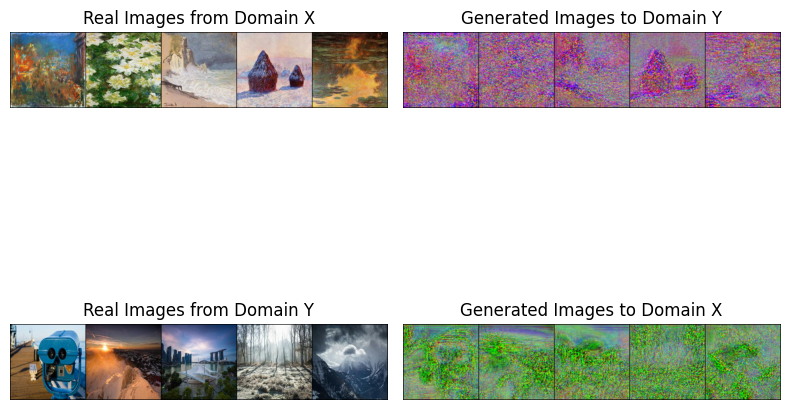

In [14]:
def sample_images(real_X, real_Y):
    G_XY.eval()
    G_YX.eval()

    real_X = real_X.type(Tensor)
    fake_Y = G_XY(real_X).detach()

    real_Y = real_Y.type(Tensor)
    fake_X = G_YX(real_Y).detach()

    ncols = real_X.size(0)
    real_X_grid = make_grid(real_X, nrow=ncols, normalize=True)
    fake_Y_grid = make_grid(fake_Y, nrow=ncols, normalize=True)
    real_Y_grid = make_grid(real_Y, nrow=ncols, normalize=True)
    fake_X_grid = make_grid(fake_X, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    axs[0, 0].imshow(real_X_grid.permute(1, 2, 0).cpu())
    axs[0, 0].set_title("Real Images from Domain X")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(fake_Y_grid.permute(1, 2, 0).cpu())
    axs[0, 1].set_title("Generated Images to Domain Y")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(real_Y_grid.permute(1, 2, 0).cpu())
    axs[1, 0].set_title("Real Images from Domain Y")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(fake_X_grid.permute(1, 2, 0).cpu())
    axs[1, 1].set_title("Generated Images to Domain X")
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

real_X, real_Y = next(iter(test_loader))
sample_images(real_X, real_Y)

**Experimentation for remaining requirements**

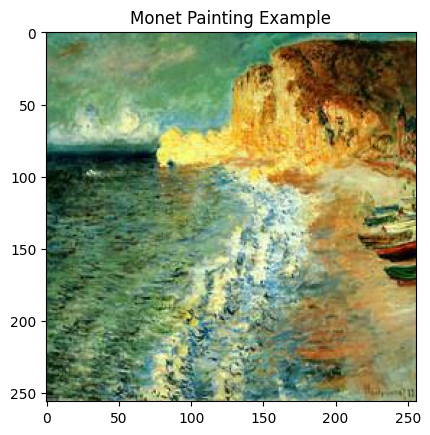

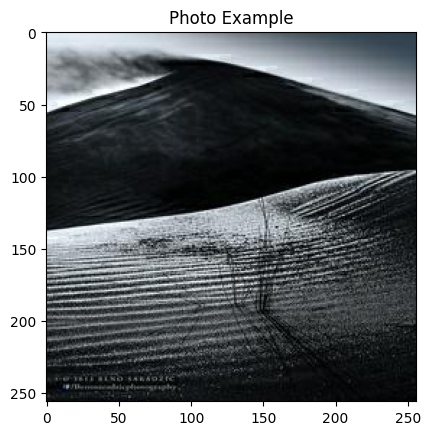

In [15]:
# Visualization code
import matplotlib.pyplot as plt
from torchvision import datasets

def load_image(path):
    return Image.open(path)

def show_images(dataset_path, title, num_images=1):
    images = os.listdir(dataset_path)
    for i in range(num_images):
        img = load_image(os.path.join(dataset_path, images[i]))
        plt.imshow(img)
        plt.title(title)
        plt.show()

# Display a photo and a Monet painting
show_images(MONET_IMAGES_PATH, 'Monet Painting Example')
show_images(TEST_IMAGES_PATH, 'Photo Example')

**Experimenting with CycleGAN class**

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

class CycleGAN(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(CycleGAN, self).__init__()
        # Initialize the generator and discriminator models
        self.generator_XtoY = GeneratorResNet(in_channels, num_residual_blocks)
        self.generator_YtoX = GeneratorResNet(in_channels, num_residual_blocks)
        self.discriminator_X = Discriminator(in_channels)
        self.discriminator_Y = Discriminator(in_channels)

    def forward(self, x, y):
        fake_y = self.generator_XtoY(x)
        fake_x = self.generator_YtoX(y)
        return fake_y, fake_x

    # Reference for Training Logic: https://blog.jaysinha.me/train-your-first-cyclegan-for-image-to-image-translation/
    def train_model(self, dataloader, epochs, lr, beta1, beta2, decay_epoch, display_epoch: int=10):
        # Create optimizers for the generators and discriminators
        optimizer_G = torch.optim.Adam(itertools.chain(self.generator_XtoY.parameters(), self.generator_YtoX.parameters()), lr=lr, betas=(beta1, beta2))
        optimizer_D_X = torch.optim.Adam(self.discriminator_X.parameters(), lr=lr, betas=(beta1, beta2))
        optimizer_D_Y = torch.optim.Adam(self.discriminator_Y.parameters(), lr=lr, betas=(beta1, beta2))

        # Create learning rate schedulers
        lr_lambda = lambda epoch: 1.0 - max(0, epoch - decay_epoch) / (epochs - decay_epoch)
        lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
        lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=lr_lambda)
        lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=lr_lambda)

        # Losses
        gan_loss = nn.MSELoss().cuda()
        cycle_loss = nn.L1Loss().cuda()
        identity_loss = nn.L1Loss().cuda()

        # Training loop
        for epoch in range(epochs):
            for x, y in dataloader:
                x, y = x.type(torch.FloatTensor), y.type(torch.FloatTensor)

                # Generate fake images
                fake_Y = self.generator_XtoY(x)
                fake_X = self.generator_YtoX(y)

                # Reconstruct images (Cycle Consistency)
                reconstructed_X = self.generator_YtoX(fake_Y)
                reconstructed_Y = self.generator_XtoY(fake_X)

                # Identity loss (Y -> Y and X -> X)
                identity_Y = self.generator_XtoY(y)
                identity_X = self.generator_YtoX(x)
                loss_identity_Y = identity_loss(identity_Y, y)
                loss_identity_X = identity_loss(identity_X, x)

                # Adversarial loss for both generators
                loss_G_XtoY = gan_loss(self.discriminator_Y(fake_Y), torch.ones_like(self.discriminator_Y(fake_Y)))
                loss_G_YtoX = gan_loss(self.discriminator_X(fake_X), torch.ones_like(self.discriminator_X(fake_X)))

                # Cycle consistency loss
                loss_cycle_XYX = cycle_loss(reconstructed_X, x)
                loss_cycle_YXY = cycle_loss(reconstructed_Y, y)

                # Total generator loss
                total_loss_G = loss_G_XtoY + loss_G_YtoX + loss_cycle_XYX + loss_cycle_YXY + loss_identity_Y + loss_identity_X
                optimizer_G.zero_grad()
                total_loss_G.backward()
                optimizer_G.step()

                # Discriminator X loss
                loss_real_X = gan_loss(self.discriminator_X(x), torch.ones_like(x))
                loss_fake_X = gan_loss(self.discriminator_X(fake_X.detach()), torch.zeros_like(fake_X))
                total_loss_D_X = (loss_real_X + loss_fake_X) / 2
                optimizer_D_X.zero_grad()
                total_loss_D_X.backward()
                optimizer_D_X.step()

                # Discriminator Y loss
                loss_real_Y = gan_loss(self.discriminator_Y(y), torch.ones_like(y))
                loss_fake_Y = gan_loss(self.discriminator_Y(fake_Y.detach()), torch.zeros_like(fake_Y))
                total_loss_D_Y = (loss_real_Y + loss_fake_Y) / 2
                optimizer_D_Y.zero_grad()
                total_loss_D_Y.backward()
                optimizer_D_Y.step()

                # Update learning rates
                lr_scheduler_G.step()
                lr_scheduler_D_X.step()
                lr_scheduler_D_Y.step()

                # Visualization and checkpointing
                if epoch % display_epoch == 0:
                    self.sample_images(x, y)
                    self.save_model(f"cyclegan_epoch_{epoch}.pth")

    def save_model(self, filename):
        torch.save(self.state_dict(), filename)

    def load_model(self, filename, device):
        self.load_state_dict(torch.load(filename, map_location=device))
        self.to(device)

    def sample_images(self, real_X, real_Y):
        self.generator_XtoY.eval()
        self.generator_YtoX.eval()

        real_X = real_X.type(torch.FloatTensor)
        fake_Y = self.generator_XtoY(real_X).detach()

        real_Y = real_Y.type(torch.FloatTensor)
        fake_X = self.generator_YtoX(real_Y).detach()

        ncols = real_X.size(0)
        real_X_grid = make_grid(real_X, nrow=ncols, normalize=True)
        fake_Y_grid = make_grid(fake_Y, nrow=ncols, normalize=True)
        real_Y_grid = make_grid(real_Y, nrow=ncols, normalize=True)
        fake_X_grid = make_grid(fake_X, nrow=ncols, normalize=True)

        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(real_X_grid.permute(1, 2, 0).cpu().numpy())
        axs[0, 0].set_title("Real Images from Domain X")
        axs[0, 0].axis('off')

        axs[0, 1].imshow(fake_Y_grid.permute(1, 2, 0).cpu().numpy())
        axs[0, 1].set_title("Generated Images to Domain Y")
        axs[0, 1].axis('off')

        axs[1, 0].imshow(real_Y_grid.permute(1, 2, 0).cpu().numpy())
        axs[1, 0].set_title("Real Images from Domain Y")
        axs[1, 0].axis('off')

        axs[1, 1].imshow(fake_X_grid.permute(1, 2, 0).cpu().numpy())
        axs[1, 1].set_title("Generated Images to Domain X")
        axs[1, 1].axis('off')

        plt.tight_layout()
        plt.show()



In [17]:
cyclegan = CycleGAN(3)
real_X, real_Y = next(iter(test_loader))

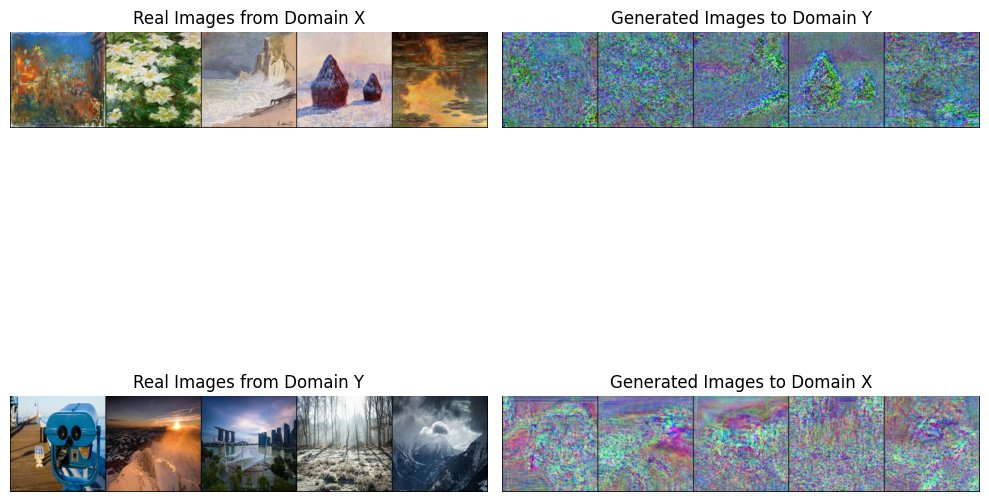

In [18]:
#Print Sample
cyclegan.sample_images(real_X, real_Y)

In [19]:
cyclegan.save_model("monet_cyclegan_model.pth")

In [ ]:
device = "cuda"
cyclegan.train_model(train_loader, n_epoches, lr, beta1, beta2, decay_epoch)

In [ ]:
#Print Sample
cyclegan.sample_images(real_X, real_Y)